In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

In [2]:
wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed_weather_labeled.csv", index_col=0) 
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

Index(['vintage', 'country', 'description', 'points', 'price', 'province',
       'region_1', 'taster_name', 'variety', 'winery',
       'similarityTop3WinesByVariety', 'word_count', 'tf_grouped_1',
       'tf_grouped_2', 'tf_grouped_3', 'tfIdf_grouped_1', 'tfIdf_grouped_2',
       'tfIdf_grouped_3', 'tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',
       'tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3', 'pr_5',
       'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8',
       'tas_9'],
      dtype='object')

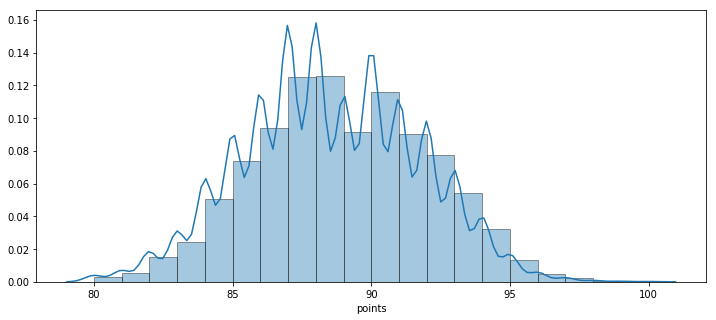

In [3]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

In [4]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  
bins

array([ 80.,  87.,  90., 100.])

10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

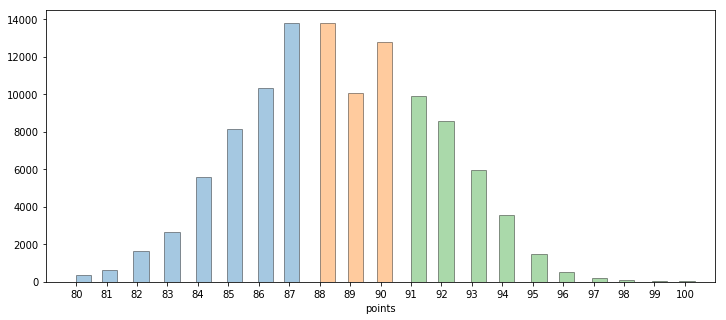

In [5]:
#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + tfGroup + word2vec

# DUMMY CLASSIFIER = BASELINE

In [ ]:
X = wine_base.loc[:,features]
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
classifier = DummyClassifier("stratified")
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)  
acc = accuracy_score(y_test,y_pred)
weightedPrec = precision_score(y_test,y_pred,average="weighted")
print(classification_report(y_test, y_pred, target_names=labels))

# CLASSIFIER WITHOUT SPARSE MATRIX

In [ ]:
def decTree(features, depth, data):
    X = data.loc[:,features]
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")

    #get feature importances
    lista = []
    for name, importance in zip(features, classifier.feature_importances_):
        lista.append([name, importance])
    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred,labels=labels)
    print(classification_report(y_test, y_pred, target_names=labels))
    return classifier

In [ ]:
features = ["price","vintage"] #basic + word2vec + word_count...
depth = 4
clf = decTree(features,depth,wine_base)

In [ ]:
#show me the tree

##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)
import pydotplus 
from sklearn import tree
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Classifier using sparse matrix

In [ ]:
def sparseMatrixRep(features,depth,data,test_size):
    X = data.loc[:,features+["description"]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    #compute countvectorizer
    vect = CountVectorizer(min_df=5)
    vect.fit(X_train['description'])
    print("vocabulary size: {}".format(len(vect.vocabulary_)))
    X_train_vectored_cv = vect.transform(X_train['description'])
    X_train_final = X_train_vectored_cv
    for feature in features:
        X_train_final = hstack((X_train_final,np.array(X_train[feature])[:,None]))
    
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train_final, y_train)
    
    y_train_pred = clf.predict(X_train_final)
    X_test_final = vect.transform(X_test['description'])
    for feature in features:
        X_test_final = hstack((X_test_final,np.array(X_test[feature])[:,None]))

    y_test_pred = clf.predict(X_test_final)
    print(classification_report(y_test, y_test_pred, target_names=labels))
    
    return clf

In [ ]:
#change the input and compute

features = ["price"] #basic #+ word + tfGroup + word2vec
depth = 3
test_size = 0.30
clf = sparseMatrixRep(features,depth,wine_base,test_size)

In [ ]:
#show me the tree
##### Graphviz sucks, you need to check if it's installed and it may give you problems anyway, the code below fixed it for me"
#### be sure that you have the package installed

import os
import sys
import pydotplus 
from sklearn import tree
from IPython.display import Image  

def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)
    
dot_data = tree.export_graphviz(clf, out_file=None,   
                             class_names=labels,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
conda_fix(graph)
Image(graph.create_png())

# Test with combinations and get results dataframe (no countvect working on this as of now)

In [6]:
#create a dataframe with every test combination you put
def testToDataFrame(algorithm,combination,Y,allfeats,dataset):
    test_size = 0.30 
    cols = ["algorithm","input","precision","accuracy","depth"]
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeats: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    row = 0
    comb = 0
    for el in combination["args"]: 
        for depth in combination["depth"]:
            row = row + 1
            X = dataset.loc[:,el]
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
            if algorithm == "decTree":
                classifier = DecisionTreeClassifier(max_depth=depth)
            else:
                classifier = RandomForestClassifier(max_depth=depth,n_estimators = estimators)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            acc = accuracy_score(y_test,y_pred)
            weightedPrec = precision_score(y_test,y_pred,average="weighted")        
            data = [algorithm,el,weightedPrec,acc,depth]
            precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
            for i in range(0,len(labels)):
                data.append(precision[i])
                data.append(recall[i])
                data.append(fscore[i])
                data.append(support[i])
            #for lab in labels:
            
             #   data.append(rep[lab].precision)     #ORDER IS VERY IMPORTANT
              #  data.append(rep[lab].recall)
               # data.append(rep[lab].f1-score)
                #data.append(rep[lab].support)
            temp = {}
            c = zip(el,classifier.feature_importances_)
            counter = 0
            for name,importance in c:
                if importance > 0:
                    temp[name] = importance
                    counter += 1
            data.append(counter)
            for feat in allfeats:
                if feat not in el:
                    data.append(100) #100 is an impossible value not to be taken into account
                else:
                    data.append(temp[feat])
            df2 = pd.DataFrame([data],columns=cols)
            results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [7]:
args = [["price"],["price","word_count"],basic,basic+tfGroup, basic+word2vec,basic+word2vec+tfGroup,word2vec,tfGroup,word2vec+tfGroup]
allfeatures = basic + word + word2vec + tfGroup 
decTreeCombinations = {"depth":[2,3,4,5],"args":args}

NameError: name 'basic' is not defined

In [ ]:
res = testToDataFrame("decTree",decTreeCombinations,Y,allfeatures,wine_base)

In [ ]:
res.sort_values(["precision",'depth'],ascending=False)

In [ ]:
res.iloc[19]

In [ ]:
res.iloc[17]

# test stuff based on countries

In [8]:
countries = wine_base["country"].unique().tolist()
countries

[8, 5, 10, 4, 2, 11, 6, 1, 3, 9, 7, 0]

In [9]:
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))

8 4639
5 1939
10 5510
4 17931
2 2784
11 48572
6 16699
1 2086
3 4046
9 1241
7 1206
0 3380


In [10]:
test = wine_base["country"].unique().tolist()
test

[8, 5, 10, 4, 2, 11, 6, 1, 3, 9, 7, 0]

In [224]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points","description"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    args = [basic + word +word2vec]
    allfeatures = basic + word + word2vec  
    combos = {"depth":[2,3,4,5,6],"args":args}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    print(type(data))
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in allfeatures: #controlla che allfeats vada bene, amgari fotte con l'ordine
        cols.append("feat_"+el)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el+["country","category"]
        print("datalop",type(data))
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = X_train["category"]
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                for name,importance in c:
                    temp[name] = importance
                for feat in allfeatures:
                    if feat not in el:
                        rowData.append(100) #100 is an impossible value not to be taken into account
                    else:
                        rowData.append(temp[feat])
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [225]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + tfGroup + word2vec


result = testByCountry(wine_base,countries)

<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
datalop <class 'pandas.core.frame.Data

In [228]:
result = result.sort_values(["ObjectiveCountry","f1"],ascending=False)
result

,algorithm,ObjectiveCountry,input,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,...,high_support,feat_price,feat_vintage,feat_province,feat_region_1,feat_taster_name,feat_variety,feat_winery,feat_word_count,feat_similarityTop3WinesByVariety
4,decTree,11,"[price, vintage, province, region_1, taster_na...",0.582644,0.542164,0.549299,6,0.616350,0.600387,0.608264,...,15631,0.763080,0.003201,0.006192,0.009496,0.077600,0.002208,0.000000,0.059864,0.078359
3,decTree,11,"[price, vintage, province, region_1, taster_na...",0.567663,0.539323,0.546904,5,0.609609,0.517025,0.559513,...,15631,0.786905,0.000000,0.000589,0.009895,0.064004,0.000880,0.000000,0.062962,0.074765
1,decTree,11,"[price, vintage, province, region_1, taster_na...",0.543547,0.529503,0.526204,3,0.574623,0.754403,0.652353,...,15631,0.921102,0.000000,0.000000,0.000000,0.019399,0.000000,0.000000,0.026945,0.032554
0,decTree,11,"[price, vintage, province, region_1, taster_na...",0.548316,0.513979,0.522297,2,0.624829,0.504386,0.558184,...,15631,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,11,"[price, vintage, province, region_1, taster_na...",0.555162,0.511859,0.519891,4,0.611033,0.507977,0.554759,...,15631,0.837061,0.000000,0.000000,0.000000,0.036324,0.000000,0.000000,0.065202,0.061414
2,decTree,10,"[price, vintage, province, region_1, taster_na...",0.688939,0.649909,0.661304,4,0.609861,0.615801,0.612816,...,1643,0.762141,0.000000,0.000000,0.000000,0.066301,0.000000,0.000000,0.159581,0.011977
3,decTree,10,"[price, vintage, province, region_1, taster_na...",0.687423,0.637750,0.650799,5,0.580769,0.653680,0.615071,...,1643,0.707306,0.003752,0.000000,0.000000,0.072424,0.000000,0.000000,0.172258,0.044261
4,decTree,10,"[price, vintage, province, region_1, taster_na...",0.684042,0.635572,0.648691,6,0.563089,0.647186,0.602216,...,1643,0.673801,0.005624,0.004801,0.000496,0.081843,0.000000,0.000000,0.181464,0.051970
1,decTree,10,"[price, vintage, province, region_1, taster_na...",0.674284,0.638657,0.647289,3,0.520117,0.769481,0.620690,...,1643,0.841170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158830,0.000000
0,decTree,10,"[price, vintage, province, region_1, taster_na...",0.597840,0.633938,0.595779,2,0.651622,0.500000,0.565830,...,1643,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [183]:
c3 = result[result["ObjectiveCountry"] == 3]


In [208]:
df1 = result.head(4)
test = result.iloc[5]
feats = []
values = []

genFeatures = []
for col in result.columns:
    if(col.startswith("feat_")):
            genFeatures.append(col)
print(genFeatures)

for col in result.columns:
    if(col.startswith("feat_")) and (test[col] != 100):
        print(col,test[col])
        feats.append(col)
        values.append(test[col])
df1

['feat_price', 'feat_vintage', 'feat_province', 'feat_region_1', 'feat_taster_name', 'feat_variety', 'feat_winery', 'feat_word_count', 'feat_similarityTop3WinesByVariety']
feat_price 0.7630797369746841
feat_vintage 0.0032014353955546948
feat_province 0.006191545769203131
feat_region_1 0.00949605752204857
feat_taster_name 0.07759988400884109
feat_variety 0.0022082266050732088
feat_winery 0.0
feat_word_count 0.059864194736516774
feat_similarityTop3WinesByVariety 0.07835891898807842


,algorithm,ObjectiveCountry,input,precision,accuracy,f1,depth,low_prec,low_recall,low_f1,...,high_support,feat_price,feat_vintage,feat_province,feat_region_1,feat_taster_name,feat_variety,feat_winery,feat_word_count,feat_similarityTop3WinesByVariety
4,decTree,0,"[price, vintage, province, region_1, taster_na...",0.737151,0.715680,0.724095,6,0.649326,0.696281,0.671984,...,840,0.680083,0.007363,0.005616,0.000593,0.077263,0.0,0.000000,0.180226,0.048857
4,decTree,5,"[price, vintage, province, region_1, taster_na...",0.594565,0.578133,0.582176,6,0.719269,0.578104,0.641007,...,854,0.694404,0.009171,0.008179,0.000000,0.065871,0.0,0.000344,0.177565,0.044466
4,decTree,3,"[price, vintage, province, region_1, taster_na...",0.725868,0.716757,0.720065,6,0.502212,0.671598,0.574684,...,1024,0.675849,0.005573,0.004294,0.010101,0.071091,0.0,0.000000,0.181781,0.051310
4,decTree,1,"[price, vintage, province, region_1, taster_na...",0.625826,0.632311,0.626138,6,0.669829,0.612847,0.640073,...,740,0.692095,0.008650,0.008344,0.004095,0.065009,0.0,0.000000,0.170450,0.051359


In [231]:
#per il radar chart, va bene probabilmente solo per la comparazione dei risultati delle importanze per linear regression e dectreeclass

#oppure anche per i risultati di precision recall e f1 score?

df = pd.DataFrame()
df = df1[["algorithm"] + genFeatures]
df = df.reset_index(drop=True)
#df.drop(["algorithm"],axis=1,inplace=True)
for col in df.columns:
    df[col] = df[col].replace(100,0)
df.drop("feat_variety",axis=1,inplace=True)
df

,algorithm,feat_price,feat_vintage,feat_province,feat_region_1,feat_taster_name,feat_winery,feat_word_count,feat_similarityTop3WinesByVariety
0,decTree,0.680083,0.007363,0.005616,0.000593,0.077263,0.000000,0.180226,0.048857
1,decTree,0.694404,0.009171,0.008179,0.000000,0.065871,0.000344,0.177565,0.044466
2,decTree,0.675849,0.005573,0.004294,0.010101,0.071091,0.000000,0.181781,0.051310
3,decTree,0.692095,0.008650,0.008344,0.004095,0.065009,0.000000,0.170450,0.051359


In [ ]:
#devi costruire il dataframe 

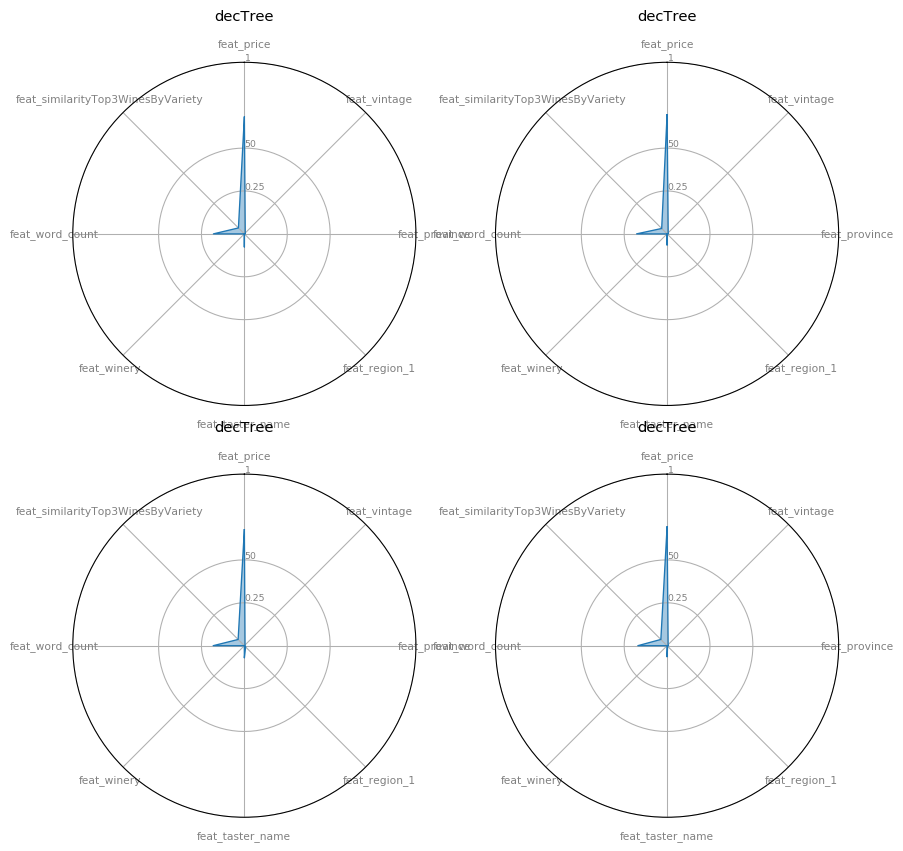

In [230]:
def make_spider(row, title):#,# color):
 
    # number of variable
    categories=list(df)[1:]
    #print(categories)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,idx+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25,0.50,1], ["0.25","50","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[idx].drop('algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1)
    ax.fill(angles, values, alpha=0.4)

    # Add a title
    plt.title(title, size=11, y=1.1)
    
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for idx,row in df.iterrows():
    make_spider(row,row["algorithm"]) #,my_palette(row))

# plots


In [ ]:
#plot scatter plot for visualizing bins by color

In [ ]:
#plot radar plot to visualize most important features for regression

In [ ]:
#plot radar plot for features in dectree

In [ ]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))

categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(2,2,row+1, polar=True, )
 
# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Ind1
values=df.loc[row].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
ax.fill(angles, values, color=color, alpha=0.4)
 
# Add a title
plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
